# Speech Emotion Recognition

#### Import the required libraries

In [1]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Audio
import IPython.display as ipd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Dropout, BatchNormalization, LSTM
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
import zipfile
import warnings
warnings.filterwarnings("ignore")

#### Download and unzip the dataset

In [2]:
!kaggle datasets download -d ejlok1/toronto-emotional-speech-set-tess
zip_ref = zipfile.ZipFile('/content/toronto-emotional-speech-set-tess.zip')
zip_ref.extractall('/content')
zip_ref.close()

Dataset URL: https://www.kaggle.com/datasets/ejlok1/toronto-emotional-speech-set-tess
License(s): Attribution-NonCommercial-NoDerivatives 4.0 International (CC BY-NC-ND 4.0)
100% 428M/428M [00:20<00:00, 21.6MB/s]
100% 428M/428M [00:20<00:00, 21.5MB/s]


In [3]:
data_dir = '/content/TESS Toronto emotional speech set data'
paths = []
labels = []

#### Extract labels and path from the dataset

In [4]:
for dirname, _, filenames in os.walk(data_dir):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename.split('_')[-1]
        label = label.replace('.wav', '')
        labels.append(label.lower())
    if len(paths) == 2800:
         break

#### Dataframe creation

In [5]:
df = pd.DataFrame()
df['label'] = labels
df['Path'] = paths

In [6]:
df['label'].value_counts()

,count
label,
fear,400
sad,400
angry,400
disgust,400
ps,400
neutral,400
happy,400


#### Function to extract MFCC features

In [7]:
def extract_mfcc(filename, duration=3, offset=0.5, sr=22050):
    y, sr = librosa.load(filename, sr=sr, duration=duration, offset=offset)
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
    return mfcc

#### Extracting MFCC for all files

In [8]:
X_mfcc = df['Path'].apply(lambda x: extract_mfcc(x))
X = np.array([x for x in X_mfcc])
X = np.expand_dims(X, -1)
X.shape

(2800, 40, 1)

#### OneHotEncoding for labels

In [9]:
enc = OneHotEncoder()
Y = enc.fit_transform(df[['label']])
Y = Y.toarray()
Y.shape

(2800, 7)

#### Split data into train and test sets

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

#### Model architecture

In [11]:
model = Sequential([
    LSTM(512, return_sequences=False, input_shape=(40, 1)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(7, activation='softmax')
])

#### Model compilation and summary

In [12]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 512)                 │       1,052,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 7)                   │             231 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,229,511 (4.69 MB)

 Trainable params: 1,228,487 (4.69 MB)

 Non-trainable params: 1,024 (4.00 KB)

#### Model training

In [13]:
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=30, batch_size=100)

Epoch 1/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.3721 - loss: 1.6298 - val_accuracy: 0.5893 - val_loss: 1.3774
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7578 - loss: 0.7190 - val_accuracy: 0.8696 - val_loss: 0.7406
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8444 - loss: 0.4637 - val_accuracy: 0.8768 - val_loss: 0.5766
Epoch 4/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9014 - loss: 0.3296 - val_accuracy: 0.8929 - val_loss: 0.4579
Epoch 5/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9230 - loss: 0.2262 - val_accuracy: 0.9375 - val_loss: 0.2797
Epoch 6/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9353 - loss: 0.2139 - val_accuracy: 0.9643 - val_loss: 0.2409
Epoch 7/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9445 - loss: 0.2133 - val_accuracy: 0.8679 - val_loss: 0.4525
Epoch 8/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9174 - loss: 0.3017 - val_accuracy: 0.9339 - v

#### Save the model file

In [14]:
model.save('model.keras')

#### Model evaluation

In [15]:
results = model.evaluate(X_test, Y_test)
print(f"Validation Accuracy: {results[1] * 100:.2f}%")

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9807 - loss: 0.0786
Validation Accuracy: 97.86%


#### Visualizing accuracy and loss over epochs

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

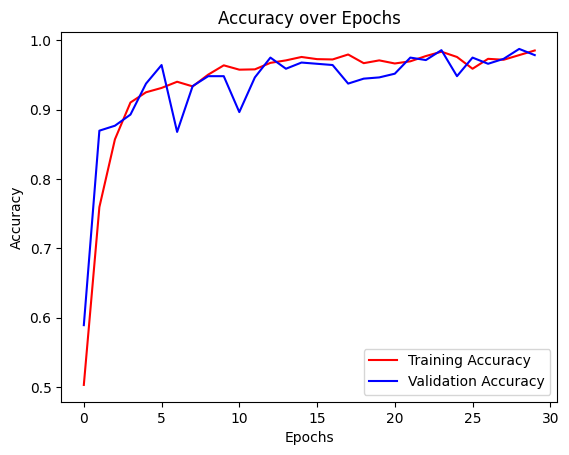

In [17]:
plt.plot(epochs_range, acc, label='Training Accuracy', color='red')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='blue')
plt.legend(loc=0)
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

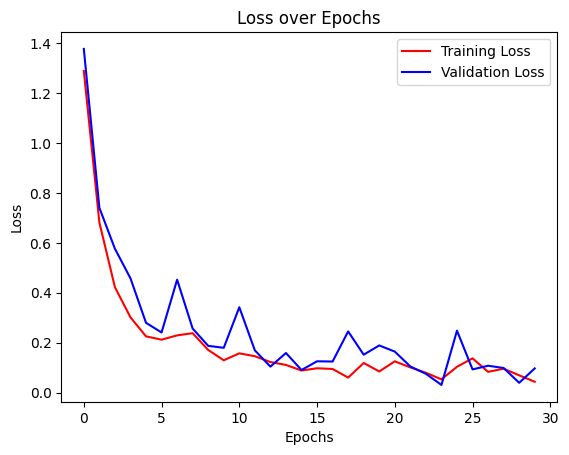

In [18]:
plt.plot(epochs_range, loss, label='Training Loss', color='red')
plt.plot(epochs_range, val_loss, label='Validation Loss', color='blue')
plt.legend(loc=0)
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

#### Model prediction

In [19]:
label_encoder = enc

def predict_emotion(file_path):
    mfcc = extract_mfcc(file_path)
    mfcc = np.expand_dims(mfcc, axis=-1)
    mfcc = np.expand_dims(mfcc, axis=0)

    prediction = model.predict(mfcc)

    emotion_index = np.argmax(prediction)

    predicted_emotion = label_encoder.categories_[0][emotion_index]
    confidence = prediction[0][emotion_index]

    return predicted_emotion, confidence

def play_audio(file_path):
    ipd.display(ipd.Audio(file_path))

def display_audio_visuals(file_path, emotion):
    data, sr = librosa.load(file_path, duration=3, offset=0.5)

    plt.title(f"Waveplot", size=20)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

    print()

    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.title(f"Spectrogram", size=20)
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()
    plt.show()

def recognize_emotion(file_path):
    predicted_emotion, confidence = predict_emotion(file_path)

    print(f"Predicted Emotion: {predicted_emotion}")
    print(f"Confidence: {confidence:.2f}")
    print()
    play_audio(file_path)
    print()
    display_audio_visuals(file_path, predicted_emotion)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
Predicted Emotion: fear
Confidence: 1.00



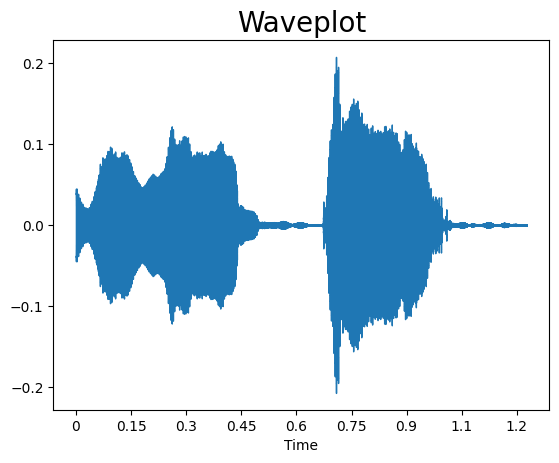

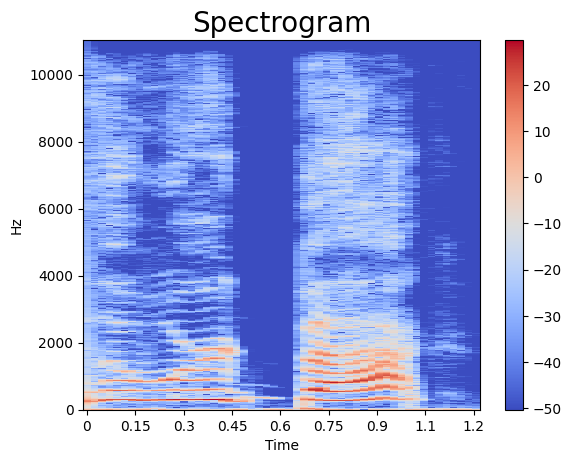

In [20]:
file_path = '/content/TESS Toronto emotional speech set data/OAF_Fear/OAF_back_fear.wav'
recognize_emotion(file_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted Emotion: ps
Confidence: 1.00



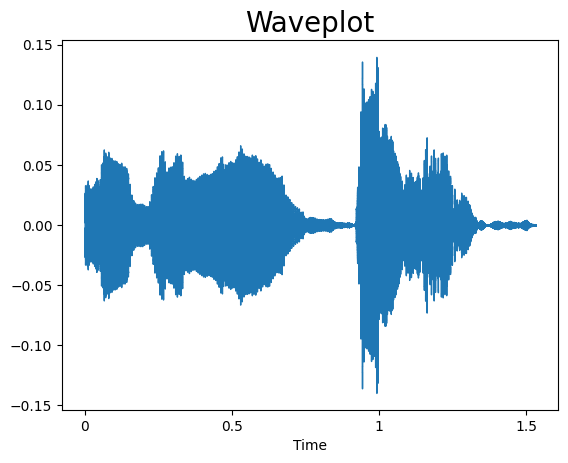

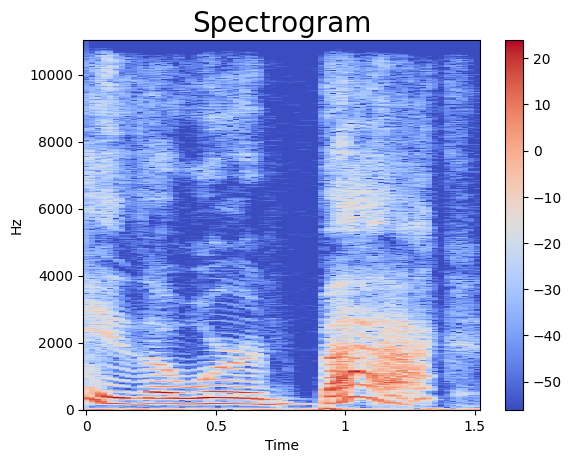

In [21]:
file_path = '/content/TESS Toronto emotional speech set data/OAF_Pleasant_surprise/OAF_back_ps.wav'
recognize_emotion(file_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted Emotion: sad
Confidence: 1.00



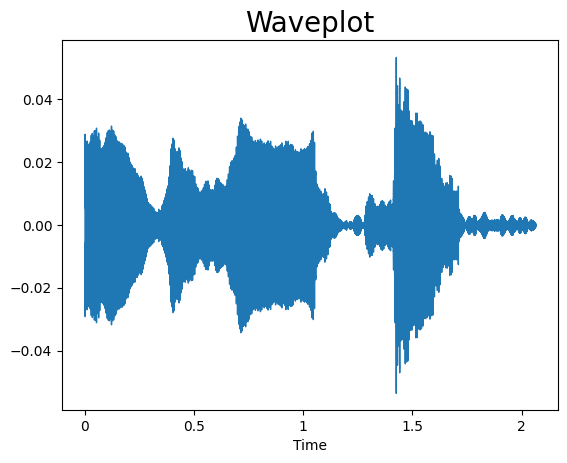

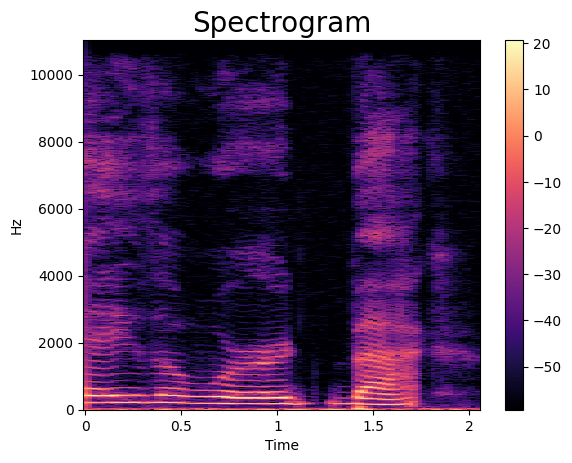

In [22]:
file_path = '/content/TESS Toronto emotional speech set data/OAF_Sad/OAF_back_sad.wav'
recognize_emotion(file_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted Emotion: angry
Confidence: 1.00



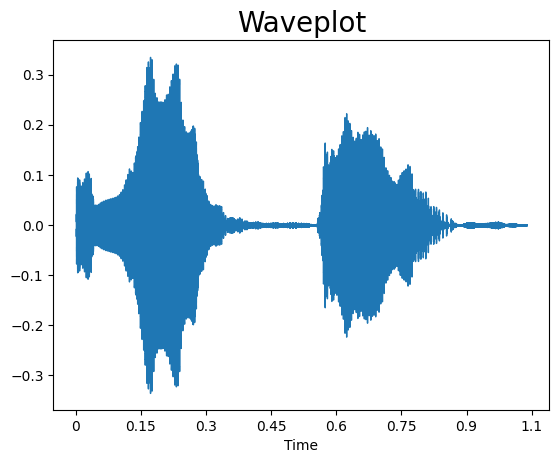

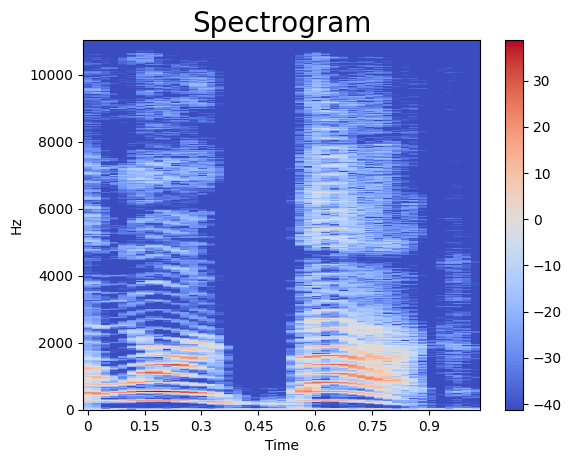

In [23]:
file_path = '/content/TESS Toronto emotional speech set data/OAF_angry/OAF_back_angry.wav'
recognize_emotion(file_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted Emotion: disgust
Confidence: 1.00



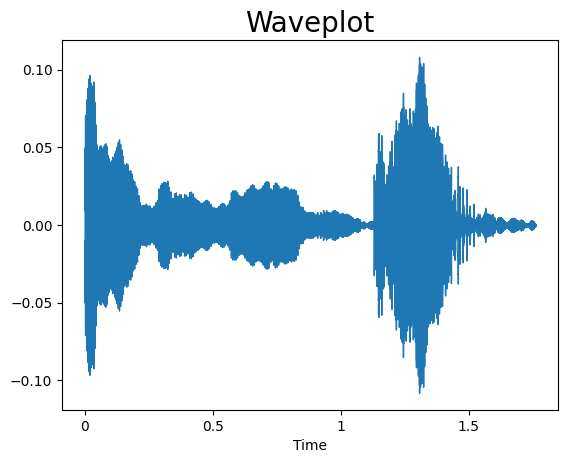

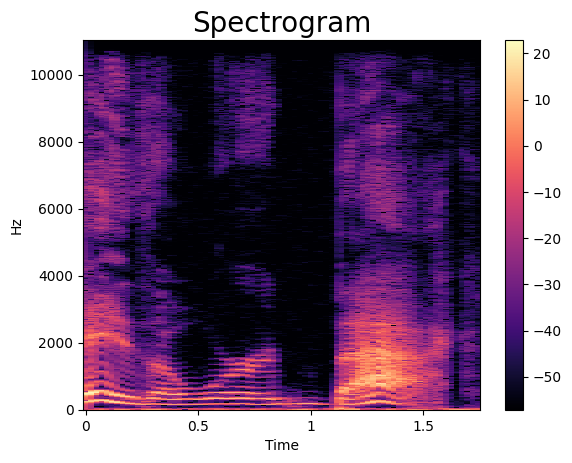

In [24]:
file_path = '/content/TESS Toronto emotional speech set data/OAF_disgust/OAF_back_disgust.wav'
recognize_emotion(file_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted Emotion: happy
Confidence: 0.96



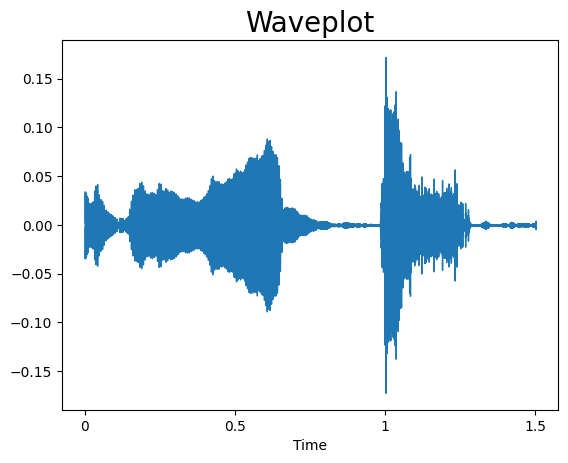

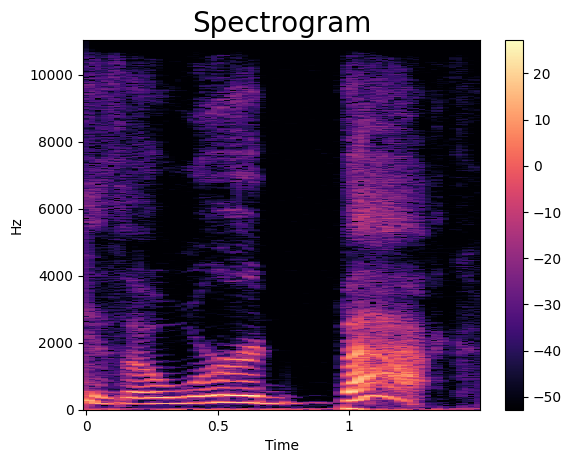

In [25]:
file_path = '/content/TESS Toronto emotional speech set data/OAF_happy/OAF_back_happy.wav'
recognize_emotion(file_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted Emotion: neutral
Confidence: 1.00



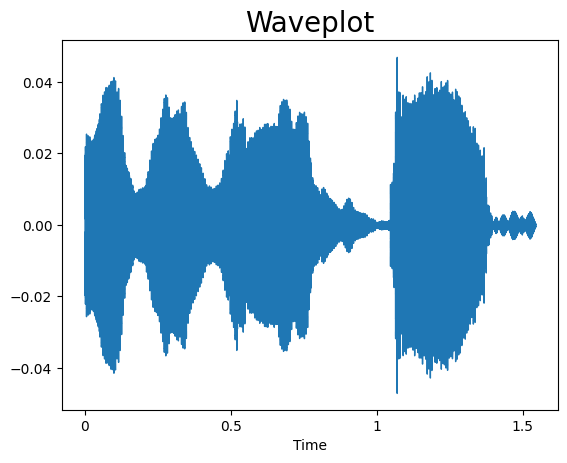

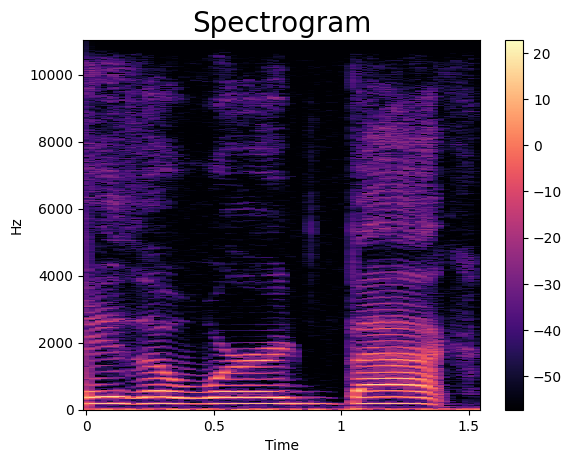

In [26]:
file_path = '/content/TESS Toronto emotional speech set data/OAF_neutral/OAF_back_neutral.wav'
recognize_emotion(file_path)